In [1]:
%load_ext autoreload
%autoreload 2

from azure.core.credentials import AzureKeyCredential
from azure.ai.formrecognizer import FormRecognizerClient

endpoint = "https://kejia-fr.cognitiveservices.azure.com/"
key = ""
credential = AzureKeyCredential(key)

form_recognizer_client = FormRecognizerClient(endpoint, credential)

In [2]:
import os
import json
import numpy as np
from math import floor, ceil
from azureml.core import Workspace, Dataset, Datastore

ws = Workspace.from_config('config.json')
datastore = Datastore(ws, "eqr_lbl_img_inp")

In [26]:
def convert_bbox(bbox, w, h):
    return [floor(bbox[0] * w), floor(bbox[1] * h),
            ceil((bbox[0] + bbox[2]) * w), ceil((bbox[1] + bbox[3]) * h)]

def intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou 

In [8]:
fpath = "NER/form-recognizer-images-4labeling/31-02-08_PB-706-1208.PDF/normalized_images_0013.jpg"
dataset = Dataset.File.from_files((datastore, fpath))

with dataset.mount() as mount_context:
    img_path = os.path.join(mount_context.mount_point, fpath.split('/')[-1])
    with open(img_path, "rb") as fd:
        form = fd.read()
    poller = form_recognizer_client.begin_recognize_content(form)
    result = poller.result()   

Downloaded path: /tmp/tmpqs676n7k/720baa08-41ad-4a93-94f4-a5f82ba906bb/NER/form-recognizer-images-4labeling/31-02-08_PB-706-1208.PDF/normalized_images_0013.jpg is different from target path: /tmp/tmpqs676n7k/720baa08-41ad-4a93-94f4-a5f82ba906bb/normalized_images_0013.jpg


In [9]:
boxs_ = []
width = result[0].to_dict()['width']
height = result[0].to_dict()['height']
words = []
for line in result[0].to_dict()['lines']:
    for word in line['words']:
        boxs_.append(word["bounding_box"])
        words.append(word)

f = lambda x: {key: [i[key] for i in x] for key in x[0]}
boxs = [f(box) for box in boxs_]
boxs = [[min(box['x']), min(box['y']), max(box['x']), max(box['y'])] for box in boxs]

In [13]:
with open('tmp.json') as f:
    tmp = json.load(f)

In [20]:
idx = 1
tmp['images'][idx-1]

{'id': 1,
 'width': 1182.0,
 'height': 1666.0,
 'file_name': 'NER/form-recognizer-images-4labeling/31-02-08_PB-706-1208.PDF/normalized_images_0013.jpg',
 'coco_url': 'AmlDatastore://eqr_lbl_img_inp/NER/form-recognizer-images-4labeling/31-02-08_PB-706-1208.PDF/normalized_images_0013.jpg',
 'absolute_url': 'https://kmogstorage.blob.core.windows.net/from-equinor/NER/form-recognizer-images-4labeling/31-02-08_PB-706-1208.PDF/normalized_images_0013.jpg',
 'date_captured': '2022-02-09T13:17:41.583368Z'}

In [22]:
t = [e for e in tmp['annotations'] if e['image_id']==idx]
t

[{'id': 1,
  'category_id': 5,
  'image_id': 1,
  'area': 0.001,
  'bbox': [0.5933032497282951,
   0.7011884176338862,
   0.06818180699502274,
   0.01768757788749553]},
 {'id': 2,
  'category_id': 6,
  'image_id': 1,
  'area': 0.001,
  'bbox': [0.6966757005260836,
   0.7017086135471328,
   0.03665690268239674,
   0.017687621546405574]},
 {'id': 3,
  'category_id': 6,
  'image_id': 1,
  'area': 0.0,
  'bbox': [0.6666169935657132,
   0.7001479384895729,
   0.023460449710968945,
   0.02080897166152529]}]

In [34]:
tt = [convert_bbox(e['bbox'], 1182, 1666) for e in t]
tt

[[701, 1168, 782, 1198], [823, 1169, 867, 1199], [787, 1166, 816, 1202]]

In [30]:
[w for w in words if w['text'] in ['traces', 'oil']]

[{'text': 'traces',
  'bounding_box': [{'x': 705.0, 'y': 1172.0},
   {'x': 777.0, 'y': 1172.0},
   {'x': 777.0, 'y': 1195.0},
   {'x': 705.0, 'y': 1195.0}],
  'confidence': 0.996,
  'page_number': 1,
  'kind': 'word'},
 {'text': 'oil',
  'bounding_box': [{'x': 822.0, 'y': 1173.0},
   {'x': 861.0, 'y': 1173.0},
   {'x': 861.0, 'y': 1194.0},
   {'x': 822.0, 'y': 1194.0}],
  'confidence': 0.997,
  'page_number': 1,
  'kind': 'word'}]

In [42]:
import numpy as np
np.argmax([intersection_over_union(tt[2], bb) for bb in boxs])

306

In [43]:
words[306]

{'text': 'of',
 'bounding_box': [{'x': 787.0, 'y': 1173.0},
  {'x': 813.0, 'y': 1173.0},
  {'x': 814.0, 'y': 1194.0},
  {'x': 787.0, 'y': 1195.0}],
 'confidence': 0.999,
 'page_number': 1,
 'kind': 'word'}

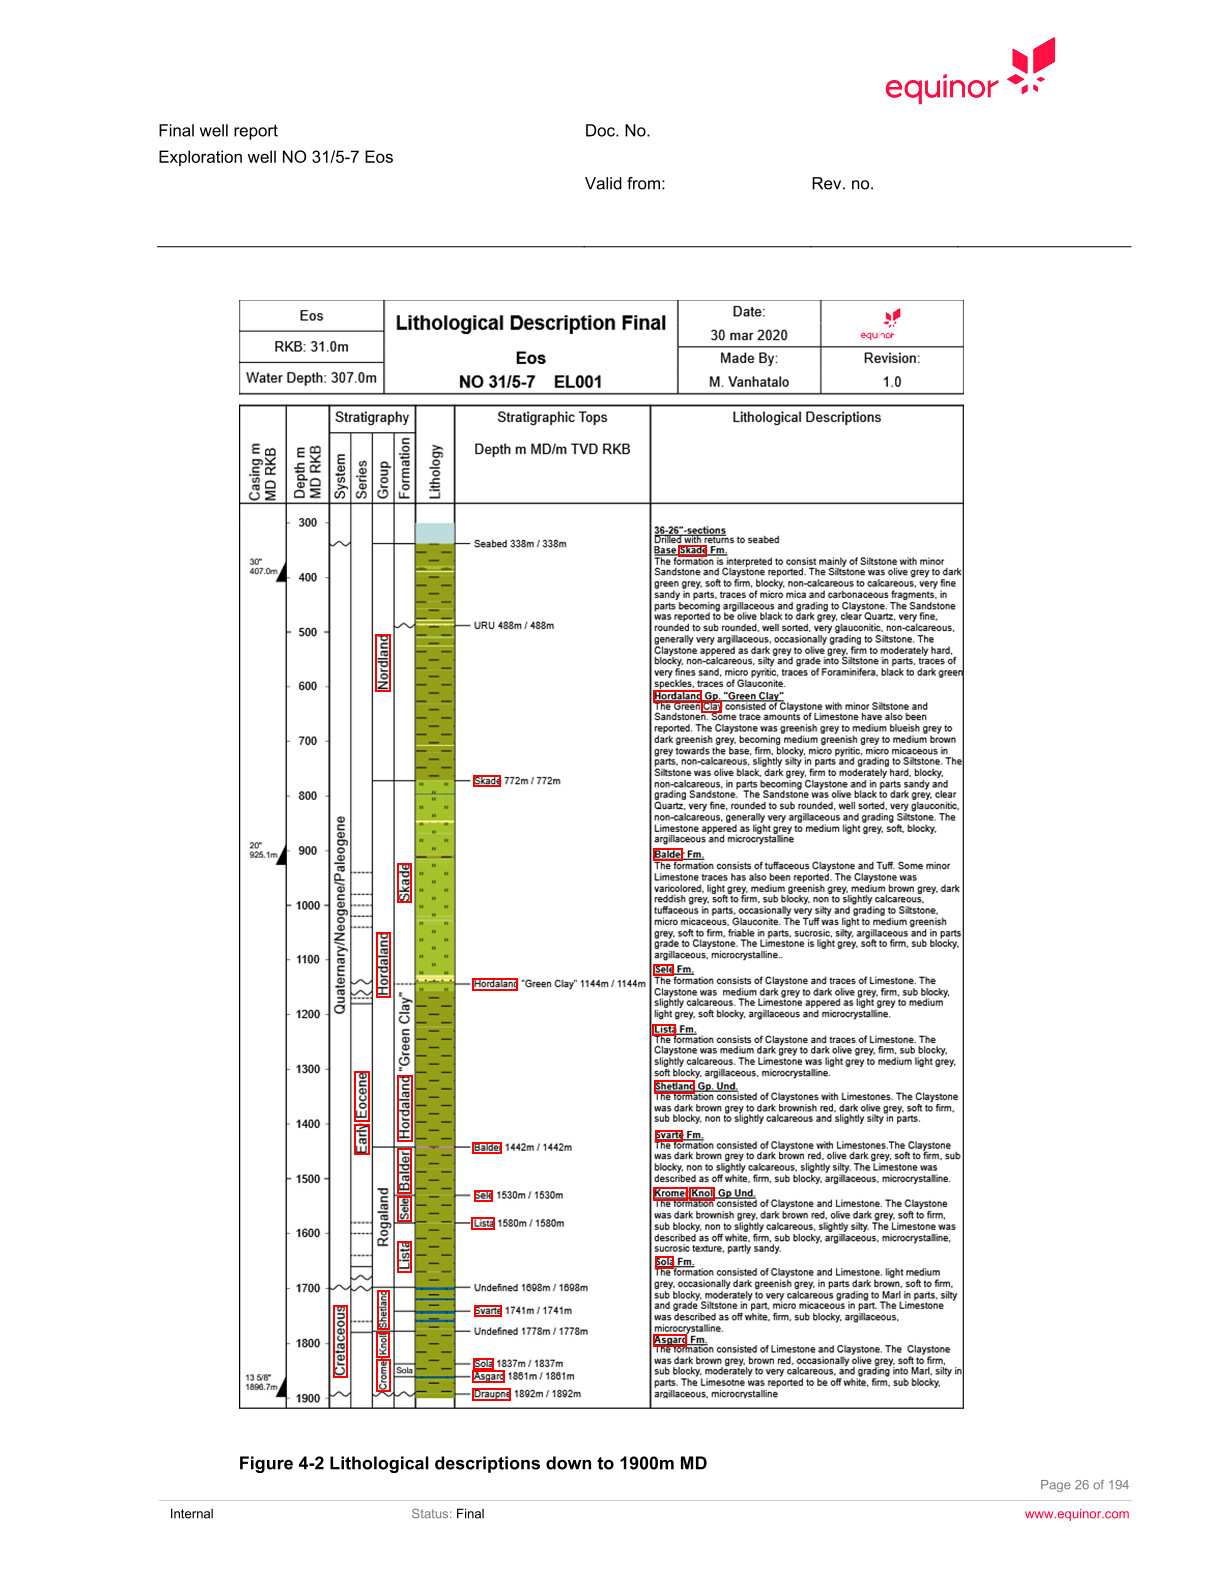

In [44]:
file_path = "COMPLETION_GEOLOGICAL_2020-09-04_REPORT_1.PDF"
page_num = "0026"
file_path = f"equinor-data/{file_path}/normalized_images_{page_num}.jpg"

with open(file_path, "rb") as fd: 
    form = fd.read()
poller = form_recognizer_client.begin_recognize_content(form)
result = poller.result()

boxs_ = []
width = result[0].to_dict()['width']
height = result[0].to_dict()['height']
words = []
for line in result[0].to_dict()['lines']:
    for word in line['words']:
        if word['text'].lower() in [
            'viking', 'draupne', 'cromer', 'knoll', 'heather', 'heather).', '(upper', 'middle', 'oxfordian', 'brent',
            'hordaland', 'early', 'miocene', 'oligocene', 'oligocene.', 'jurassic', 'holocene', 'eocene', 'paleocene',
            'dunlin', 'statfjord', 'triassic', 'pleistocene', 'lower', 'cret', 'shetland', 'upper', 'quaternary', 'tertiary',
            'nordland', 'utsira', 'pleistocene', 'maastrichtian', 'oxfordian', 'callovian', 'bathonian', 'bajocian', 'toarcian',
            'pliensbachian', 'sinemurian', 'pliocene', 'late', 'tarbert', 'cretaceous', 'jurassic.', 'sognefjord',
            'aalenian', 'toarcian-', 'latest', 'toarcian.', 'maast.', 'u.camp.', 'u.campan.', 'kimm.', 'callovian',
            'callovian,', 'volgian', 'ryazanian', 'kimmeridge', 'clay', 'neocomian', 'albian', 'hauterivian', 'nordland', 
            'nordland', 'quaternary?', '"miocene"', 'sinemurian', 'hettangian', 'drake', 'skade', 'svarte', 'kromer', 'knoll',
            'lista', 'sola', 'balder', 'sele', 'asgard'
        ]:
            boxs_.append(word["bounding_box"])
            words.append(word)

f = lambda x: {key: [i[key] for i in x] for key in x[0]}
boxs = [f(box) for box in boxs_]
boxs = [[min(box['x']), min(box['y']), max(box['x']), max(box['y'])] for box in boxs]

from PIL import Image, ImageDraw, ImageFont
image = Image.open(file_path)
draw = ImageDraw.Draw(image, "RGBA")
for box in boxs:
    draw.rectangle(box, width=2, outline="red")
image

In [369]:
labels = ["B-form", "B-form", "B-form", "B-form", "B-form", "B-chron", "B-chron", "I-chron"
         ]
assert len(words) == len(labels)

words_w_labels = []
for word, label in zip(words, labels):
    word["label"] = label
    words_w_labels.append(word)

dict_labeled[file_path] = words_w_labels

len(dict_labeled)

import pickle
with open('dict_labeled.pkl', 'wb') as f:
    pickle.dump(dict_labeled, f)

# Generating the dataset

In [13]:
from tqdm.notebook import tqdm
import os

def normalize_bbox(bbox, width, height):
     return [
         int(1000 * (bbox[0] / width)),
         int(1000 * (bbox[1] / height)),
         int(1000 * (bbox[2] / width)),
         int(1000 * (bbox[3] / height)),
     ]

def generate_annotations(path: str):
  annotation_files = []
  for js in tqdm(os.listdir(path)):
    with open(path + js) as f:
        annotation_files.append(json.load(f))
  
  words = []
  boxes = []
  labels = []
  for js in tqdm(annotation_files):
      words_example = []
      boxes_example = []
      labels_example = []

      width, height = js['meta']['image_size']['width'], js['meta']['image_size']['height']
      # loop over OCR annotations
      for elem in js['valid_line']:
          for word in elem['words']:
              # get word
              txt = word['text']

              # get bounding box
              # important: each bounding box should be in (upper left, lower right) format
              # it took me some time to understand the upper left is (x1, y3)
              # and the lower right is (x3, y1)
              x1 = word['quad']['x1']
              y1 = word['quad']['y1']
              x3 = word['quad']['x3']
              y3 = word['quad']['y3']
              
              box = [x1, y1, x3, y3]
              box = normalize_bbox(box, width=width, height=height)

              # ADDED
              # skip empty word
              if len(txt) < 1: 
                continue
              if min(box) < 0 or max(box) > 1000: # another bug in which a box had -4
                continue
              if ((box[3] - box[1]) < 0) or ((box[2] - box[0]) < 0): # another bug in which a box difference was -12
                continue
              # ADDED

              words_example.append(txt)
              boxes_example.append(box) 
              labels_example.append(elem['category'])
      words.append(words_example) 
      boxes.append(boxes_example)
      labels.append(labels_example)
  
  return words, boxes, labels

Let's apply the function above for the training, validation and test set:

In [14]:
train_path = 'data/train/json/'
val_path = 'data/dev/json/'
test_path = 'data/test/json/'

words_train, boxes_train, labels_train = generate_annotations(train_path)
words_val, boxes_val, labels_val = generate_annotations(val_path)
words_test, boxes_test, labels_test = generate_annotations(test_path)

  0%|          | 0/787 [00:00<?, ?it/s]

  0%|          | 0/787 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
labels_train[0]

['menu.cnt',
 'menu.cnt',
 'menu.nm',
 'menu.cnt',
 'menu.unitprice',
 'menu.price',
 'menu.nm',
 'menu.cnt',
 'menu.unitprice',
 'menu.price',
 'sub_total.subtotal_price',
 'sub_total.subtotal_price',
 'total.total_price',
 'total.total_price',
 'total.creditcardprice',
 'total.creditcardprice',
 'total.creditcardprice',
 'total.changeprice',
 'total.changeprice']

In [16]:
words_train[0]

['x',
 'x',
 'PEPPERONI',
 '1',
 '23,000',
 '23,000',
 'ALMOND CREAM CHEESE',
 '1',
 '28,000',
 '28,000',
 'SUB TOTAL',
 '51,000',
 'GRAND TOTAL',
 '51,000',
 'MASTER',
 '2080',
 '51,000',
 'CHANGE DUE',
 '0']

In [17]:
boxes_train[0]

[[298, 516, 319, 532],
 [293, 567, 314, 583],
 [236, 486, 396, 509],
 [240, 515, 254, 530],
 [335, 515, 423, 533],
 [712, 523, 798, 543],
 [231, 534, 568, 561],
 [236, 566, 250, 581],
 [331, 563, 420, 587],
 [712, 572, 798, 592],
 [199, 600, 353, 623],
 [710, 611, 798, 631],
 [192, 656, 390, 679],
 [715, 662, 804, 684],
 [182, 699, 305, 719],
 [305, 699, 375, 719],
 [719, 703, 812, 725],
 [175, 742, 370, 763],
 [796, 746, 817, 766]]

# Saving

In [19]:
import pickle
with open('data/train.pkl', 'wb') as t:
    pickle.dump([words_train, labels_train, boxes_train], t)
with open('data/dev.pkl', 'wb') as t:
    pickle.dump([words_val, labels_val, boxes_val], t)
with open('data/test.pkl', 'wb') as t:
    pickle.dump([words_test, labels_test, boxes_test], t)